In [2]:
from netCDF4 import Dataset
import numpy as np
from numpy import sin, cos, tan, arctan, deg2rad, rad2deg
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

In [3]:
d_deg = 0.1
Radius = 6.371e6
center_lon_inDeg, center_lat_inDeg = 0.0, -75.0

center_lon, center_lat = deg2rad(center_lon_inDeg), deg2rad(center_lat_inDeg)

xtolerance = 20
ytolerance = 20

x_start_indeg = -xtolerance - center_lon_inDeg
x_end_indeg = xtolerance + center_lon_inDeg
y_start_indeg = center_lat_inDeg - ytolerance
y_end_indeg = center_lat_inDeg + ytolerance

x_start = deg2rad(x_start_indeg)
x_end = deg2rad(x_end_indeg)
y_start = deg2rad(y_start_indeg)
y_end = deg2rad(y_end_indeg)

d_deg_inRad = deg2rad(d_deg)

x_range = x_end - x_start
y_range = y_end - y_start
print(y_range)
print('lat range', rad2deg(y_start), rad2deg(y_end))

ylen = int(y_range//d_deg_inRad)
xlen = int(x_range//d_deg_inRad)

print('ylen, xlen' , ylen, xlen)

lat = np.linspace(y_start, y_end, ylen)
lon = np.linspace(x_start, x_end, xlen)

LON, LAT = np.meshgrid(lon, lat)
dlat = lat[1] - lat[0]
dlon = lon[1] - lon[0]

dX = Radius * cos(LAT)*dlon
dY = np.full((ylen, xlen), Radius * dlat)
UAREA = dX*dY



0.6981317007977319
lat range -95.0 -55.0
ylen, xlen 400 399


In [5]:
def getGeodesicDistFromLonLat(center_lon, center_lat, LON, LAT, Radius):
    phi2 = (LAT)
    phi1 = (center_lat)
    dlambda = (LON - center_lon)
    num = np.sqrt((cos(phi2) * sin(dlambda))**2 +(cos(phi1)* sin(phi2) - sin(phi1)*cos(phi2)* cos(dlambda))**2)
    den = (sin(phi1)*sin(phi2) + cos(phi1)*cos(phi2) * cos(dlambda))
    dsigma = np.arctan2(num,den)
    r = Radius*dsigma
    return r


def getXYlengthsFromLonLat(center_lon, center_lat, LON, LAT, Radius):
    dlat_fromCenter = LAT - center_lat
    dlon_fromCenter = LON - center_lon
    X = Radius * cos((LAT))*dlon_fromCenter
    Y = Radius * (dlat_fromCenter)
    return X, Y


def getKernel(rinKm, ellinKm, UAREA):
    #G = (0.5 - 0.5*np.tanh((rinKm - ellinKm/2)/10))
    G = np.ones(rinKm.shape)
    G[rinKm > ellinKm/2] = 0.0
    normalization = np.nansum(G*UAREA)
    kernel = G/normalization
    return kernel 

def getConst(rInKm, X, Y, UAREA, ellInKm):
    kernel = getKernel(rInKm, ellInKm, UAREA)
    intgX = np.nansum(X**2 * UAREA * kernel)/(ellInKm*1e3)**2 
    intgY = np.nansum(Y**2 * UAREA * kernel)/(ellInKm*1e3)**2 
    intgXY = np.nansum(X*Y * UAREA * kernel)/(ellInKm*1e3)**2 
    intgYX = np.nansum(Y*X * UAREA * kernel)/(ellInKm*1e3)**2 
    return (intgX+intgY+intgXY+intgYX)
    

-1.3089969389957472
1.0


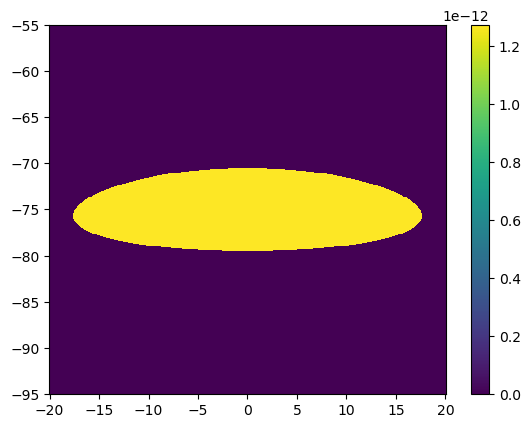

In [6]:
ell = 1000e3

r = getGeodesicDistFromLonLat(center_lon, center_lat, LON, LAT, Radius)
X, Y = getXYlengthsFromLonLat(center_lon, center_lat, LON, LAT, Radius)
kernel = getKernel(r/1e3, ell/1e3, UAREA)
print(center_lat)




plt.pcolormesh(rad2deg(lon), rad2deg(lat), kernel)
#plt.pcolormesh(X/1e3, Y/1e3, kernel)
plt.colorbar()
print(np.sum(kernel*UAREA))

# Definition of functions

In [22]:
a = 3
b = 4

c = 5
d = 12

# fxy = b*X/(Radius/2)  #a*np.sin(2*np.pi*LON/x_range)# + 
# f2xy = d*X/(Radius/2)  #c*np.cos(2*np.pi*LAT/y_range)# +

# f1 = a*np.sin(2*np.pi*LON/x_range)# + 
# f2 = c*np.cos(2*np.pi*LON/x_range)# +

X_range_meters = np.array(xlen*[X[:,-1] - X[:,0]]).T
f1 = a*np.sin(2*np.pi*X/X_range_meters)# + 
f2 = c*np.cos(2*np.pi*X/X_range_meters)# +

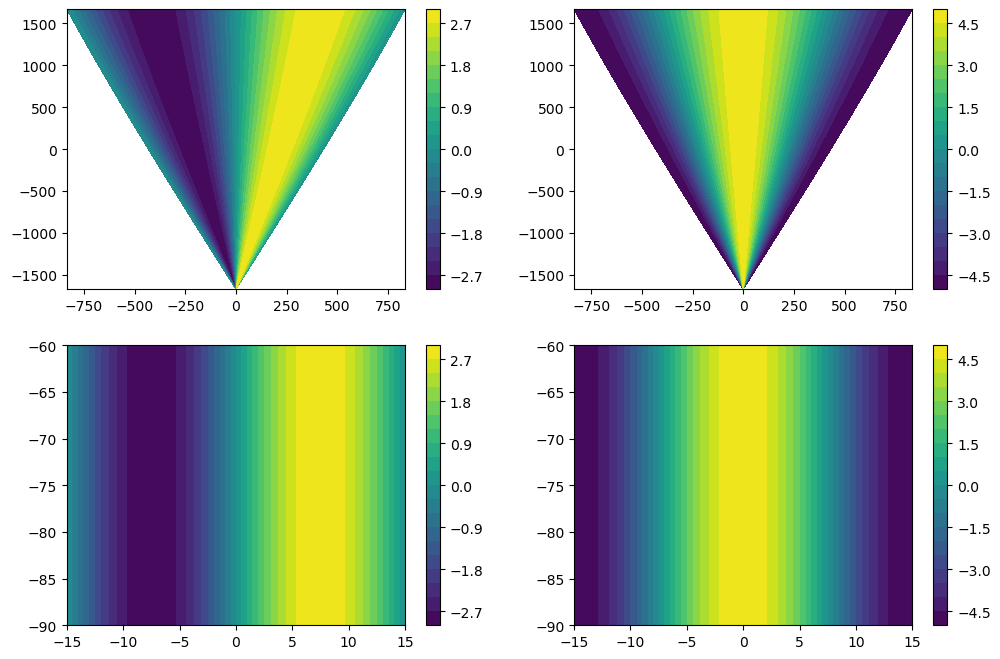

In [23]:
nlevels = 20

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
m = ax[0,0].contourf(X/1e3, Y/1e3, f1, levels=nlevels)
plt.colorbar(m, ax=ax[0, 0])

m = ax[0,1].contourf(X/1e3, Y/1e3, f2, levels=nlevels)
plt.colorbar(m, ax=ax[0, 1])

m = ax[1,0].contourf(rad2deg(lon), rad2deg(lat), f1, levels=nlevels)
plt.colorbar(m, ax=ax[1, 0])

m = ax[1,1].contourf(rad2deg(lon), rad2deg(lat), f2, levels=nlevels)
plt.colorbar(m, ax=ax[1, 1])

0.014316613975638427


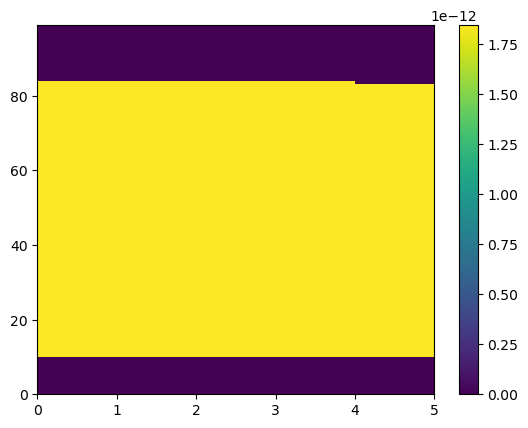

In [7]:
midId_x = int(xlen//2)
midId_y = int(ylen//2)


startId_x = np.argmin(abs(X[midId_y,:] - (-ell/2)))- 5
endId_x = np.argmin(abs(X[midId_y,:] - (ell/2)))+ 5

startId_y = np.argmin(abs(Y[:, midId_x] - (-ell/2)))- 5
endId_y = np.argmin(abs(Y[:, midId_x] - (ell/2)))+ 5

ker =  kernel[startId_y:endId_y, startId_x:endId_x]
uarea =  UAREA[startId_y:endId_y, startId_x:endId_x]

plt.pcolormesh(ker)
plt.colorbar()

print(np.sum(ker*uarea))

In [8]:
f1bar = signal.convolve2d(f1, ker*uarea, mode='same', boundary='wrap')
f2bar = signal.convolve2d(f2, ker*uarea, mode='same', boundary='wrap')
f1f2bar = signal.convolve2d(f1*f2, ker*uarea, mode='same', boundary='wrap')

In [9]:
f1.shape, f1bar.shape, ker.shape

((300, 299), (300, 299), (99, 5))

In [10]:
f2.shape, f2bar.shape, ker.shape, 

((300, 299), (300, 299), (99, 5))

0.029998332927628296
2.956904927689146 -2.956904927689146


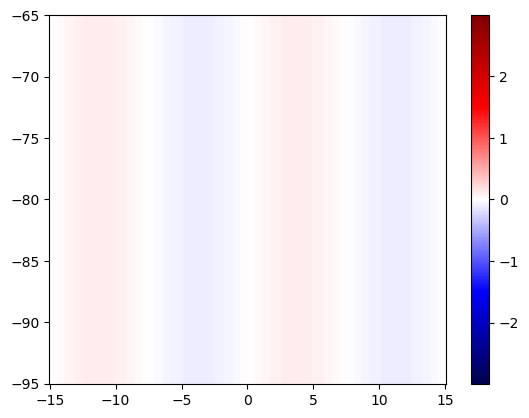

In [11]:
s, e = 0, xlen#63,500-63
f1 = f1#[s:e, s:e]
f2 = f2#[s:e, s:e]
v=np.max(f1)
print(0.01*v)
plt.pcolormesh(rad2deg(LON), rad2deg(LAT), f1f2bar-f1bar*f2bar, cmap='seismic', vmin=-v, vmax=v)
print(np.max(f1-f1bar), np.min(f1-f1bar))
plt.colorbar()

In [12]:
def GetGradientPOP2(Array2D, DXU, DYU, UAREA):
    p = -1
    m = 1
    x = 1
    y = 0
    topRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (p,p), axis=(y,x)) +\
               np.roll(Array2D, p, axis=y))
    
    topLeft = 0.25*(Array2D + np.roll(Array2D, p, axis=y) +\
               np.roll(Array2D, (p,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=x))
    
    bottomRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (m,p), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    bottomLeft = 0.25*(Array2D + np.roll(Array2D, m, axis=x) +\
               np.roll(Array2D, (m,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    gradx = 0.5*(topRight + bottomRight - topLeft - bottomLeft)/DX
    grady = 0.5*(topRight + topLeft - bottomRight - bottomLeft)/DY
    
    return gradx, grady

def GetGradient_order(phi, DX, DY):
    n=4
    coeffs = np.array([1./280, -4./105, 1./5, -4./5, 0, 4./5, -1./5, 4./105, -1./280], dtype=float)
    

    dx_phi = np.zeros(phi.shape, dtype=float)
    dy_phi = np.zeros(phi.shape, dtype=float)
    
    
    for i in range(-n, n+1):
        dx_phi += np.roll(phi, i, axis = 1) * -coeffs[n+i]
        dy_phi += np.roll(phi, i, axis = 0) * -coeffs[n+i]
        #print(i, coeffs[n+i])
    
    dx_phi = dx_phi/DX
    dy_phi = dy_phi/DY
    
    return dx_phi, dy_phi

def GetGradient(phi, DX, DY, UAREA):
    dx_phi, dy_phi = GetGradient_order(phi, DX, DY)#, UAREA)     
    return dx_phi, dy_phi


def getModelVal(f1_bar, f2_bar, DX, DY, ell):
    C_2 = 2*(ell**2)/8
    dx_f1, dy_f1 = GetGradient(f1_bar, DX, DY, DX*DY)
    dx_f2, dy_f2 = GetGradient(f2_bar, DX, DY, DX*DY)

    model = dx_f1 * dx_f2 +\
            dy_f1 * dy_f2

    model *= C_2

    return model

def getModel2Val(f1_bar, f2_bar, DX, DY, ell):
    C_2 = 0.125
    dx_f1, dy_f1 = GetGradient(f1_bar, DX, DY, DX*DY)
    dx_f2, dy_f2 = GetGradient(f2_bar, DX, DY, DX*DY)

    model = dx_f1 * dx_f2 +\
            dy_f1 * dy_f2

    model *= (1/2 * (ell)**2 * C_2)

    return model

In [13]:
truth = f1f2bar - f1bar*f2bar
model = getModelVal(f1bar, f2bar, dX, dY, ell)
model2 = getModel2Val(f1bar, f2bar, dX, dY, ell)

Text(0.5, 1.0, 'Model at -80 deg lat')

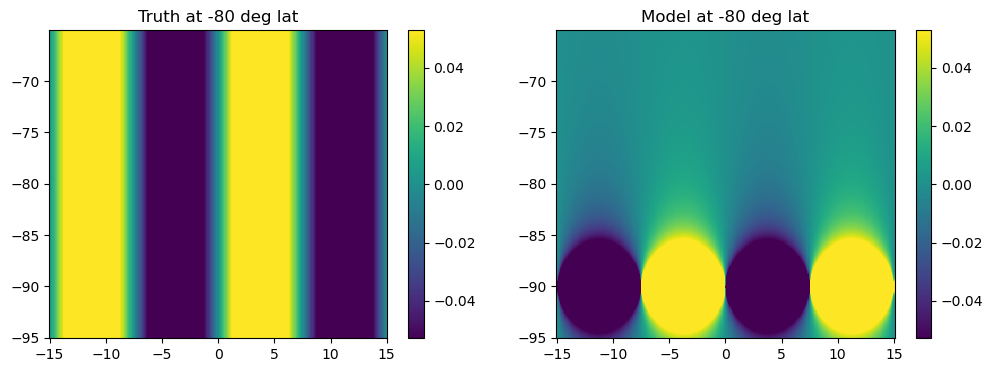

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

v = np.max(truth)/2
n=0
x1,x2 = n,xlen-n
y1,y2 = n,ylen-n
cmap = plt.get_cmap('viridis')
p = ax[0].pcolormesh(rad2deg(LON)[x1:x2, y1:y2], rad2deg(LAT)[x1:x2, y1:y2], truth[x1:x2, y1:y2], 
                   cmap=cmap, vmin=-v, vmax=v)
plt.colorbar(p, ax=ax[0])
ax[0].set_title('Truth at {0:2.0f} deg lat'.format(center_lat_inDeg))

p = ax[1].pcolormesh(rad2deg(LON)[x1:x2, y1:y2], rad2deg(LAT)[x1:x2, y1:y2], model2[x1:x2, y1:y2], 
                   cmap=cmap, vmin=-v, vmax=v)
plt.colorbar(p, ax=ax[1])
ax[1].set_title('Model at {0:3.0f} deg lat'.format(center_lat_inDeg))

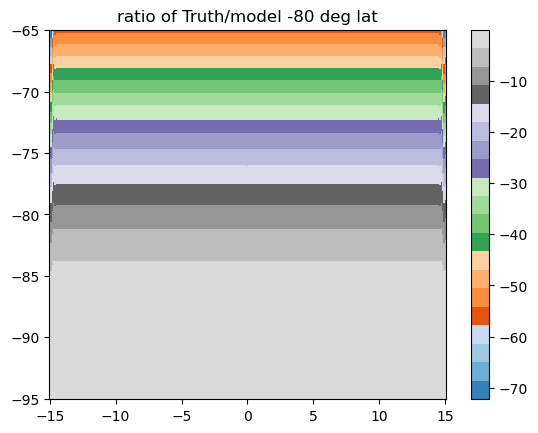

In [15]:
plt.pcolormesh(rad2deg(LON), rad2deg(LAT), truth/model2, cmap='tab20c') 
plt.title("ratio of Truth/model {0:3.0f} deg lat".format(center_lat_inDeg))
plt.colorbar()